In [2]:
# install transformers, preferably in a conda environment
#! pip  install transformers
#! pip install matplotlib

## Fine-tune the DiabloGPT model based on characters from Seinfeld.
Inspired from https://towardsdatascience.com/make-your-own-rick-sanchez-bot-with-transformers-and-dialogpt-fine-tuning-f85e6d1f4e30

In [1]:
import os
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

os.chdir('..')

In [3]:
!pwd

/data/isshamie/SeinChat


In [ ]:
character = "GEORGE" # "JERRY", "KRAMER", "ELAINE"


## Load DiabloGPT-medium model and tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

### Uncomment the following to see what the dialogue looks like before fine-tuning

In [6]:
# # Let's chat for 5 lines
# for step in range(5):
#     # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

#     # append the new user input tokens to the chat history
#     bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

#     # generated a response while limiting the total chat history to 1000 tokens    
#     chat_history_ids = model.generate(
#     bot_input_ids, max_length=1000,
#     pad_token_id=tokenizer.eos_token_id
#     )

#     # pretty print last ouput tokens from bot
#     print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

## Model initial configuration

Let's train our Seinfeld character chatbot. For start, we will need basic configuration and a dataset.
Configuration and training scripts are mostly based on this [script](https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_language_modeling.py) from Huggingface and great [tutorial](https://nathancooper.io/i-am-a-nerd/chatbot/deep-learning/gpt2/2020/05/12/chatbot-part-1.html) from Nathan Cooper.

In [7]:
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
import torch.optim as optim

from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

/data/isshamie/miniconda3/envs/sein/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output_diablomedium'
        self.model_type = 'gpt2'
        self.model_name_or_path = "microsoft/DialoGPT-medium"
        self.config_name = "microsoft/DialoGPT-medium"
        self.tokenizer_name = "microsoft/DialoGPT-medium"
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 8
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 15000
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## Prepare Dataset

In [9]:
# Let's look at original dataset
all_sein = pd.read_csv('data/sein_scripts_kaggle/scripts.csv', index_col=0)
all_sein.head(10)

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,GEORGE,Are you through?,1.0,S01E01,1.0
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0
5,JERRY,"Oh, you dont recall?",1.0,S01E01,1.0
6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",1.0,S01E01,1.0
7,JERRY,"Well, senator, Id just like to know, what you ...",1.0,S01E01,1.0
8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,1.0,S01E01,1.0
9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",1.0,S01E01,1.0


### Remove the parenthesis in Dialogue

In [10]:
import re
# text = "heyu (rherhe ) (rjerj)"
# print(str(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)))

def rm_parenthesis(text):
    return str(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)).replace("(", "").replace(")", "")

all_sein['Dialogue'] = all_sein['Dialogue'].fillna("").apply(rm_parenthesis)

In [11]:
all_sein.head()

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,JERRY,"See, to me, that button is in the worst possi...",1.0,S01E01,1.0
2,GEORGE,Are you through?,1.0,S01E01,1.0
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0


In [12]:
all_sein["Character"] = all_sein["Character"].str.upper()

We will convert this dataset in a way that every responce row will contain **n** previous responces as a context. For our purposes seven previous responces will be enough.
This runs for each character, so it gets a character response and the seven previous lines of dialogue

In [ ]:
n=7

In [13]:
def run_context(character,  n=7, verbose=False):
    contexted = []
    # find the indices where the character speaks, break down for each episode so no cross over
    episodes_groups = all_sein.groupby("SEID")
    for ep, ep_df in episodes_groups:
        ep_df = ep_df.reset_index()
        curr_char_inds = ep_df[ep_df["Character"] == character].index
        if verbose:
            print(f"number of {character} lines in episode {ep}: {len(curr_char_inds)}")
        for i_line in curr_char_inds:
            if i_line <= n: # too early in episode. 
                continue
            row = []
            prev = i_line - 1 - n # we additionally substract 1, so row will contain current responce and 7 previous responces  
            for j in range(i_line, prev, -1):
                row.append(ep_df['Dialogue'][j])
            contexted.append(row)        
    return contexted



running jerry
running george


In [ ]:

# print('running jerry')
# jerry_contexted = run_context("JERRY", n=n, verbose=False)
# print('running george')
# george_contexted = run_context("GEORGE", n=n, verbose=False)

# jerry_contexted[:5]

# # Rick n mortys old was 1898
# contexted = george_contexted
# len(contexted)

# print(len(george_contexted))
# print(len(jerry_contexted))


contexted = run_context(character, n=n, verbose=False)
print(len(character))

In [17]:
columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(n-1)]
columns

['response',
 'context',
 'context/0',
 'context/1',
 'context/2',
 'context/3',
 'context/4',
 'context/5']

In [18]:
df = pd.DataFrame.from_records(contexted, columns=columns)
df.head(5)

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,"Are, are you sure this is decaf? Wheres the or...",Mr. Seinfeld. Mr. Costanza.,"Well, senator, Id just like to know, what you ...","Uh, no, not at this time.","Oh, you dont recall?","Yes, it was purple, I liked it, I dont actuall...","You do of course try on, when you buy?",Are you through?
1,How come youre not doin the second show tomorrow?,Trust me George. No one has any interest in se...,"Can you relax, its a cup of coffee. Claire is ...","Its missing, I have to do it in my head decaf ...","Are, are you sure this is decaf? Wheres the or...",Mr. Seinfeld. Mr. Costanza.,"Well, senator, Id just like to know, what you ...","Uh, no, not at this time."
2,"Wait a second, wait a second, what coming in, ...","Well, theres this uh, woman might be comin in.",How come youre not doin the second show tomorrow?,Trust me George. No one has any interest in se...,"Can you relax, its a cup of coffee. Claire is ...","Its missing, I have to do it in my head decaf ...","Are, are you sure this is decaf? Wheres the or...",Mr. Seinfeld. Mr. Costanza.
3,"No, you didnt!","I told you about Laura, the girl I met in Mich...","Wait a second, wait a second, what coming in, ...","Well, theres this uh, woman might be comin in.",How come youre not doin the second show tomorrow?,Trust me George. No one has any interest in se...,"Can you relax, its a cup of coffee. Claire is ...","Its missing, I have to do it in my head decaf ..."
4,Ha.,"I thought I told you about it, yes, she teache...","No, you didnt!","I told you about Laura, the girl I met in Mich...","Wait a second, wait a second, what coming in, ...","Well, theres this uh, woman might be comin in.",How come youre not doin the second show tomorrow?,Trust me George. No one has any interest in se...


Split our dataset into a training and test parts.

In [19]:
trn_df, val_df = train_test_split(df, test_size = 0.1)
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
5712,"""....I like spicy chicken""","""What's that?""","""George likes spicy chicken.""","""I don't know how you can eat that spicy chick...","""'Cause when he questioned me about it I was s...","""Why?""","""I have to go see Steinbrenner later. Mr Wilhe...","""Jimmy's gonna put the moves on Elaine.."""
6654,Well now it's not gonna be original! It's gon...,I can't believe that they're using it.,What?! They're stealing the name?! That's my ...,They're gonna name their baby Seven.,"So, what're you saying?","Well I was telling Carrie about our argument, ...",Why not?,"Well, I dunno how original it's gonna be any m..."
550,I couldn't take it anymore.,Get outta here.,I quit my job.,I don't know.,Kramer. Guess what.,How did you know I was here?,Guess what.,"Whatever it costs. In fact, I would prefer it ..."
6947,S'cuse me ..Do you mind if I ask you a few que...,Oooooh ...Pops .... Wow!! Spectacular.,Behold .. The Technicolor Dreamcoat.,Oh yeah!!,Well that's the grand tour ... Aw but I save t...,OKAY!!!,Like a shrimp farmer....,Ok....
2861,It wasn't that bad.,"Ooo, that was a bad toast.",Do you know the last time I wore this thing? S...,"Well, well, look at you. It?s a little skimpy ...","What, are you locking the door now?",It's George.,Who is it?,"But officer, he threatened me! I don't unders..."


Now will convert our dataset in a format suitable for our model. Basically we will concatenate responses in one string for each row (additionally we will add special 'end of string' token between responses, so the model will understand end of each response in a string).  

In [20]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):
        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)
        #block_size = block_size - (tokenizer.max_len - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [21]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

## Training and Evaluating

There will be quite a lot of code needed for training our model but don’t worry, everything should work as is, the main thing is to give the model the dataset in the right format.

In [22]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_last_lr()[0], global_step)
                    #tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()
        
    plt.plot(tr_loss/global_step)

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [23]:
# Main runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelForCausalLM.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelForCausalLM.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

08/19/2022 12:33:30 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False


08/19/2022 12:33:47 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x7f3a4f70b3a0>
08/19/2022 12:33:47 - INFO - __main__ -   Creating features from dataset file at cached
08/19/2022 12:33:50 - INFO - __main__ -   Saving features into cached file cached/gpt2_cached_lm_512
08/19/2022 12:33:50 - INFO - __main__ -   ***** Running training *****
08/19/2022 12:33:50 - INFO - __main__ -     Num examples = 8443
08/19/2022 12:33:50 - INFO - __main__ -     Num Epochs = 8
08/19/2022 12:33:50 - INFO - __main__ -     Instantaneous batch size per GPU = 4
08/19/2022 12:33:50 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 4
08/19/2022 12:33:50 - INFO - __main__ -     Gradient Accumulation steps = 1
08/19/2022 12:33:50 - INFO - __main__ -     Total optimization steps = 16880


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2110 [00:00<?, ?it/s]

08/19/2022 13:21:19 - INFO - __main__ -   Saving model checkpoint to output_diablomedium/checkpoint-15000
08/19/2022 13:21:22 - INFO - __main__ -   Saving optimizer and scheduler states to output_diablomedium/checkpoint-15000
08/19/2022 13:27:18 - INFO - __main__ -    global_step = 16880, average loss = 1.1029613109323155
08/19/2022 13:27:18 - INFO - __main__ -   Saving model checkpoint to output_diablomedium
08/19/2022 13:27:23 - INFO - __main__ -   Evaluate the following checkpoints: ['output_diablomedium']
08/19/2022 13:27:25 - INFO - __main__ -   Creating features from dataset file at cached
08/19/2022 13:27:26 - INFO - __main__ -   Saving features into cached file cached/gpt2_cached_lm_512
08/19/2022 13:27:26 - INFO - __main__ -   ***** Running evaluation  *****
08/19/2022 13:27:26 - INFO - __main__ -     Num examples = 939
08/19/2022 13:27:26 - INFO - __main__ -     Batch size = 4


Evaluating:   0%|          | 0/234 [00:00<?, ?it/s]

08/19/2022 13:27:36 - INFO - __main__ -   ***** Eval results  *****
08/19/2022 13:27:37 - INFO - __main__ -     perplexity = tensor(2.5510)


{'perplexity_': tensor(2.5510)}

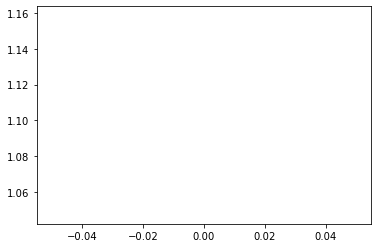

In [24]:
main(trn_df, val_df)

## Chatting with the character

The model is ready, so it's time to chat.


In [28]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained('output_diablomedium')

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=1000, 
        top_p=0.7,
        num_beams=10,
        temperature = 0.9,
        #num_beams=5, 
    )
    
    # pretty print last ouput tokens from bot
    print("SeinBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Who are you?
SeinBot: I'm him.
>> User:What do you do for a living?
SeinBot: Im an architect.
>> User:What buildings have you designed?
SeinBot: Uh, I uh, I've designed some uh... some pretty nifty buildings.
>> User:Maybe you can show me the buildings sometime
SeinBot: !!! remindme 30 seconds
>> User:What's your take on society in general?
SeinBot: ! remind me 30 seconds.


In [31]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained('output_diablomedium')

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=10000, 
        num_beams=15,
        temperature = 0.7,
    )
    
    # pretty print last ouput tokens from bot
    print("SeinBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Who are you?
SeinBot: I'm him.
>> User:Can you be more specific?
SeinBot: Specific, I want specific.
>> User:Tell me your real name
SeinBot: Stephens.
>> User:Tell me your first and last name
SeinBot: Nelson.
>> User:I thought you were george costanza
SeinBot: !!!,!!


In [32]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained('output_diablomedium')

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=10000, 
        temperature = 0.7,
    )
    
    # pretty print last ouput tokens from bot
    print("SeinBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:What do you think about Jerry Seinfeld?
SeinBot: Let me hear your thoughts.
>> User:I asked you first
SeinBot: I'm Cuban.
>> User:You make no sense
SeinBot: I know what I'm talking about.
>> User:Seems like you are lying
SeinBot: !!!?!!,!!.
>> User:ok
SeinBot: !?,!,,!??!?...!!...!?


In [33]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained('output_diablomedium')

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=500, 
        top_p=0.7,
        temperature = 0.9,
        #num_beams=5, 
    )
    
    # pretty print last ouput tokens from bot
    print("SeinBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:What do you think of Jerry Seinfeld?
SeinBot:  I don't know.
>> User:Do you like your parents?
SeinBot: [] No.
>> User:What's your take on bathrooms
SeinBot: I think it's fantastic.
>> User:What is your job?
SeinBot: I'm an architect.
>> User:What kind of buildings have you designed?
SeinBot: !!!,!!


In [34]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained('output_diablomedium')

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=500, 
        top_p=0.7,
        temperature = 0.5,
        num_beams=100, 
    )
    
    # pretty print last ouput tokens from bot
    print("SeinBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Who are you
SeinBot: I'm him.
>> User:What do you think of Jerry Seinfeld?
SeinBot: I like him. He's honest.
>> User:That's great. But even when he lied about having cancer?
SeinBot: That was a different time.
>> User:You're a good friend. So anyway which movie do you want to see?
SeinBot: !!! remindme 30 seconds
>> User:That is not the answer I was hoping for. What are you doing later today?
SeinBot: ?!!?!??!.!!.
